## Script for training ready-for-discharge (RFD) classifiers using multiple source cross-validation. 

#### TODO: implement multiple folds per source when using both MIMIC and GICU.

In [1]:
import pandas as pd
import numpy as np
import bisect
import pickle
import yaml
from pathlib import Path

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, brier_score_loss
from sklearn.metrics import auc as auc_metric
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer, f1_score, accuracy_score
from sklearn.model_selection import PredefinedSplit

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
original_features = [
    'airway', 'fio2', 'spo2_min', 
    'hco3', 'resp_min', 'resp_max', 
    'bp_min', 'hr_min', 'hr_max', 'pain', 
    'gcs_min', 'temp_min', 'temp_max', 
    'haemoglobin', 'k','na','creatinine','bun'
] 

config = {
    'data_sources': ['mimic'],  # 'gicu' can be included or omitted to train on MIMIC only
    'feature_set': 'extended',  # 'extended' includes demographic features
    'features': {
        'original': original_features,
        'extended': original_features + ['bmi', 'los', 'age', 'sex']
    },
    'fit_score': None,  # optimise hyperparameters according to this score (e.g. 'f1')
    'n_splits': 1,  # number of repeated train:test splits to evaluate for peformance statistics
    'random_seed': 42,
    'missing_data_treatment': 'imputed',  # or 'completecase'
    'data_directory': Path('./fms/'),
    'results_directory': Path('./results'),
    'fpr_range': np.linspace(0.1, 1, 10),  # flase positive rates at which to evaluate relevant performance metrics
    'cv_folds': 5,  # number of cross-validation folds to use (currently only used when GICU is omitted)
    'test_size': 0.4  # fraction to hold out for test
}

In [3]:
features = config['features'][config['feature_set']]

with open(config['results_directory'] / 'config.yaml', 'w') as out_file:
    yaml.dump(config, out_file)

In [9]:
def fm_path(data_source, missing_data, feature_set, standardised=True):  
    
    file_name = "fm_%s_%s_%s" % (data_source, missing_data, feature_set) 
    
    if standardised:
        file_name = file_name + '_standardised'
    
    return (config['data_directory'] / file_name).with_suffix('.csv')

In [8]:
fm_mimic = pd.read_csv(fm_path('mimic', config['missing_data_treatment'], config['feature_set']))

fm_gicu = (
    pd.read_csv(fm_path('gicu', config['missing_data_treatment'], config['feature_set']))
    if 'gicu' in config['data_sources']
    else None
)

In [6]:
fm_mimic

,ICUSTAY_ID,creatinine,fio2,bp_min,pain,k,hr_min,hr_max,gcs_min,bun,...,spo2_min,temp_min,temp_max,na,cohort,outcome,age,sex,bmi,los
0,200289,-0.454324,0.858020,2.097520,1.636770,1.053740,0.339921,-0.209961,0.653257,-0.752025,...,-0.323219,0.962418,0.871899,-0.681992,1,0,-0.180179,1.059280,-0.002022,-0.642663
1,200325,-0.578874,0.271680,0.948187,-0.666619,-0.694704,-0.503532,-0.854532,-1.089980,-0.565256,...,1.134850,0.795946,0.711183,0.151165,1,0,-0.364582,1.059280,-0.041011,0.868301
2,200352,1.725310,-0.267753,-0.057483,-0.666619,0.470925,-1.282100,-1.499100,0.653257,0.648742,...,0.551621,-0.619060,-0.654909,-0.890281,1,0,-0.014216,1.059280,-0.034690,-0.591085
3,200671,-0.578874,-0.021490,-1.302600,-0.666619,-0.306161,0.988730,1.020580,0.653257,-0.565256,...,-1.198060,0.296532,0.229033,1.609190,1,0,-0.014216,1.059280,-0.019029,-0.438625
4,201004,-0.578874,-0.021490,-0.057483,1.636770,-1.083250,-0.827936,-1.030320,0.304609,-0.938794,...,1.134850,0.463004,0.389749,-1.306860,1,0,-0.954673,1.059280,-0.015900,-0.325386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13238,298981,-0.578874,-0.314660,-0.249040,-0.666619,-0.111890,-1.346980,-1.030320,-0.044038,-0.892102,...,0.551621,0.463004,0.389749,0.359455,1,1,-0.290821,-0.944036,-0.048364,-0.173123
13239,299046,-0.578874,0.271680,-0.296929,1.636770,-1.083250,0.210159,0.141623,0.653257,-0.938794,...,-0.031605,0.379768,0.309391,0.567744,1,1,-0.917792,1.059280,0.084703,-0.401122
13240,299652,-0.142948,1.444360,-0.392707,3.172360,0.082382,1.248250,1.372170,0.653257,-0.752025,...,-0.614832,1.295360,1.675480,0.567744,1,1,4.190180,1.059280,-0.019923,-0.555553
13241,299764,-0.267498,-2.660020,2.049640,-0.282721,0.276653,1.183370,0.903388,0.653257,-0.705333,...,-0.323219,1.628300,1.514770,0.776033,1,1,-0.475224,-0.944036,0.091427,-0.576161


In [27]:
fm_mimic_orig['resp_min']

0        11.0
1        19.0
2        20.0
3        29.0
4        19.0
         ... 
13238    23.0
13239    20.0
13240    14.0
13241    11.0
13242    17.0
Name: resp_min, Length: 13243, dtype: float64

In [26]:
fm_mimic_orig.dtypes

ICUSTAY_ID       int64
creatinine     float64
fio2           float64
bp_min           int64
pain           float64
k              float64
hr_min           int64
hr_max           int64
gcs_min        float64
bun            float64
hco3           float64
airway         float64
resp_min       float64
resp_max       float64
haemoglobin    float64
spo2_min         int64
temp_min       float64
temp_max       float64
na               int64
cohort           int64
outcome          int64
age              int64
sex              int64
bmi            float64
los            float64
dtype: object

In [12]:
features

['airway',
 'fio2',
 'spo2_min',
 'hco3',
 'resp_min',
 'resp_max',
 'bp_min',
 'hr_min',
 'hr_max',
 'pain',
 'gcs_min',
 'temp_min',
 'temp_max',
 'haemoglobin',
 'k',
 'na',
 'creatinine',
 'bun',
 'bmi',
 'los',
 'age',
 'sex']

/home/expert/Documents/work/smartt/algorithms/old_rfd_model/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  import sys


array([[<AxesSubplot:title={'center':'airway'}>,
        <AxesSubplot:title={'center':'fio2'}>,
        <AxesSubplot:title={'center':'spo2_min'}>,
        <AxesSubplot:title={'center':'hco3'}>,
        <AxesSubplot:title={'center':'resp_min'}>],
       [<AxesSubplot:title={'center':'resp_max'}>,
        <AxesSubplot:title={'center':'bp_min'}>,
        <AxesSubplot:title={'center':'hr_min'}>,
        <AxesSubplot:title={'center':'hr_max'}>,
        <AxesSubplot:title={'center':'pain'}>],
       [<AxesSubplot:title={'center':'gcs_min'}>,
        <AxesSubplot:title={'center':'temp_min'}>,
        <AxesSubplot:title={'center':'temp_max'}>,
        <AxesSubplot:title={'center':'haemoglobin'}>,
        <AxesSubplot:title={'center':'k'}>],
       [<AxesSubplot:title={'center':'na'}>,
        <AxesSubplot:title={'center':'creatinine'}>,
        <AxesSubplot:title={'center':'bun'}>,
        <AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'los'}>],
       [<AxesSubplot

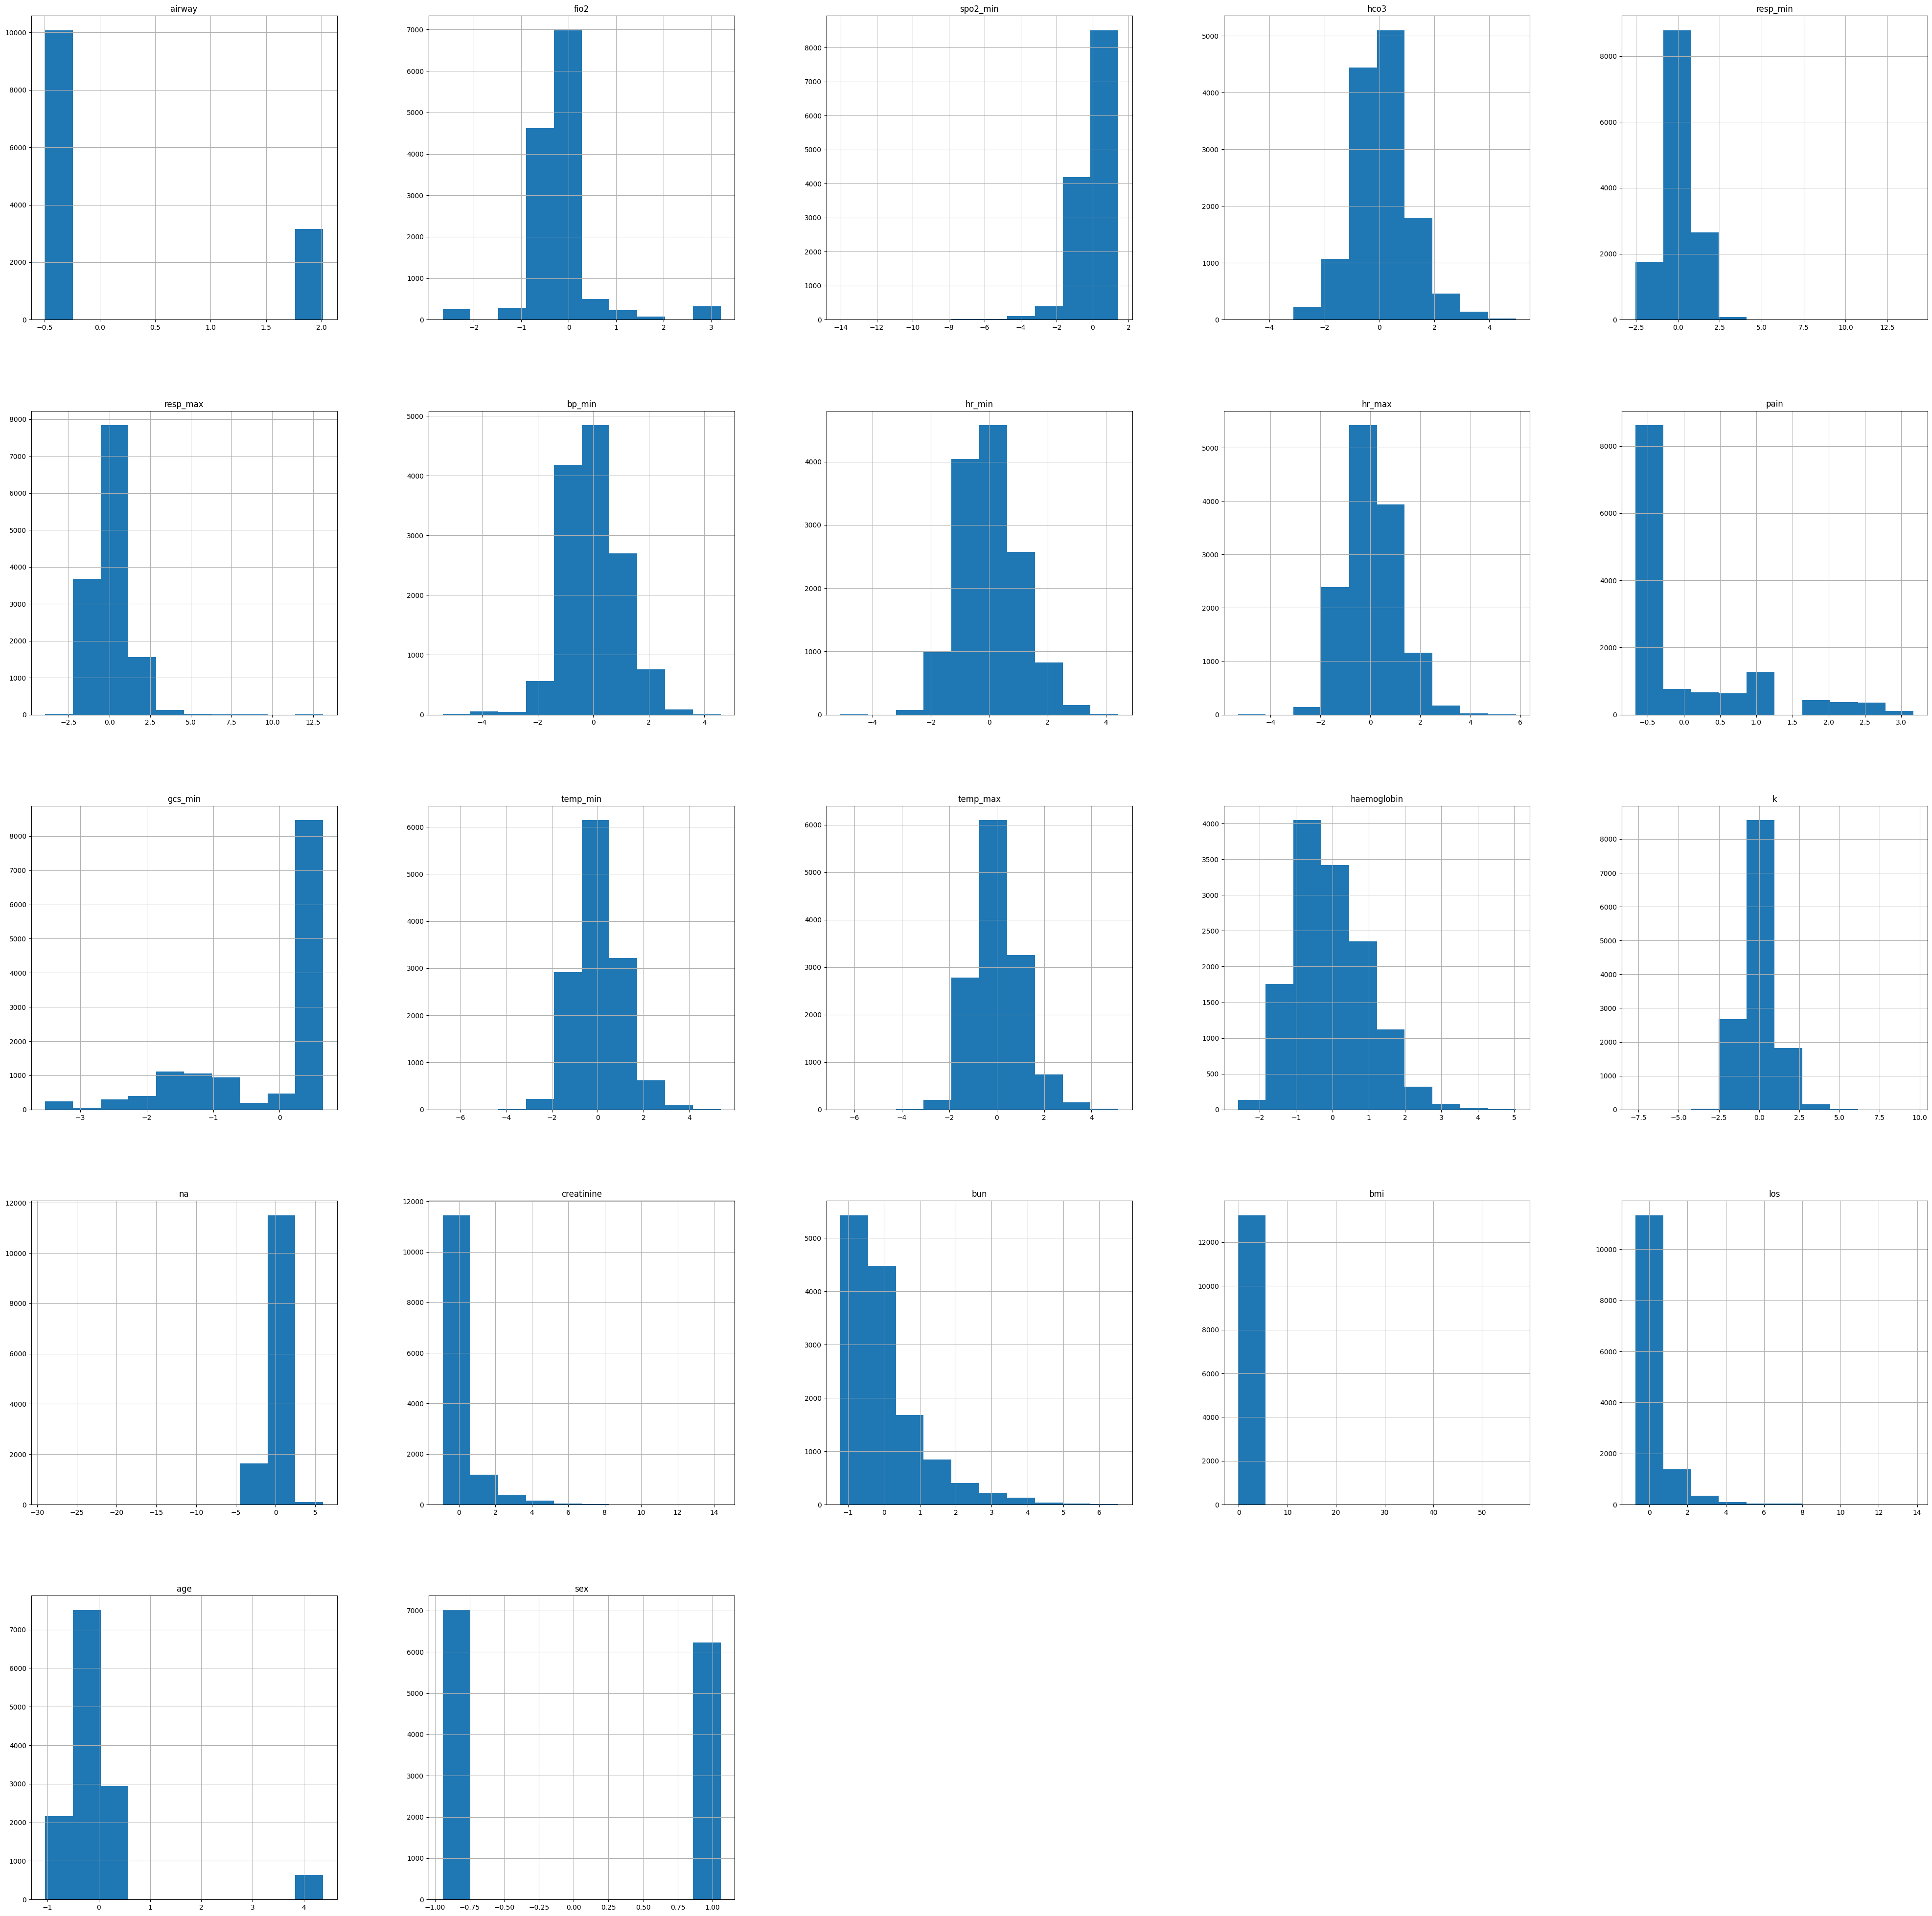

In [25]:
# plt.figure(figsize=(10,50))
# # axes = plt.subplots(len(features), 1)
# for ai, feature in enumerate(features):
#     ax=plt.subplot(len(features), 1, ai+1)
#     fm_mimic[feature].hist(ax=ax)#, xlabel=feature)
fig=plt.figure(figsize=(50,50))
fm_mimic[features].hist(ax=fig)

In [6]:
print("MIMIC cohort contains: ", len(fm_mimic), " patients.")
if 'gicu' in config['data_sources']:
    print("GICU cohort contains: ", len(fm_gicu), " patients.")

MIMIC cohort contains:  13243  patients.


In [7]:
def split_data(mimic, gicu, test_size=config['test_size'], seed=config['random_seed'], VERBOSE=True):
    
    if gicu is not None:
        # first we split the smaller GICU data according to test_size
        g_train, g_test = train_test_split(fm_gicu, test_size=test_size, random_state=seed)

        # then split MIMIC such that size of m_test equals that of g_test
        mfrac = len(g_test) / len(fm_mimic)
        
    else:
        g_train = None
        g_test = None
        mfrac = test_size
        
    m_train, m_test = train_test_split(fm_mimic, test_size=mfrac, random_state=seed)
    
    if VERBOSE:
        print("Using %.4f of MIMIC as training data" %(1-mfrac))
        print("giving test sets gicu_test:%d and mimic_test:%d" %(len(g_test) if g_test is not None else 0,len(m_test)))
    
    return m_train, m_test, g_train, g_test

In [8]:
_,_,_,_ = split_data(fm_mimic, fm_gicu)

Using 0.6000 of MIMIC as training data
giving test sets gicu_test:0 and mimic_test:5298


In [9]:
def get_fpr_tpr_for_threshold(fpr, tpr, threshold, prob_thresholds):
    p = bisect.bisect_left(fpr, threshold)
    fpr = fpr.copy()
    fpr[p] = threshold
    return fpr[: p + 1], tpr[: p + 1], prob_thresholds[: p + 1]

def partial_auc_score(y, y_pred, threshold=0.5):
    fpr, tpr, prob_thresholds = roc_curve(y, y_pred, pos_label=1) 
    fpr_t, tpr_t, _ = get_fpr_tpr_for_threshold(fpr, tpr, threshold, prob_thresholds)
    
    return auc_metric(fpr_t,tpr_t) 

def calculate_all_metrics(ytrue, ypred, fpr_thresh):
    
    results = {}
    fpr, tpr, prob_thresholds = roc_curve(ytrue, ypred, pos_label=1) 
    fpr_t, tpr_t, cutoff = get_fpr_tpr_for_threshold(fpr, tpr, fpr_thresh, prob_thresholds)
    
    ypred_class = ypred>=cutoff[-1]
    
    results['f1'] = f1_score(ytrue, ypred_class)
    results['accuracy'] = accuracy_score(ytrue, ypred_class)
    results['sensitivity'] = tpr_t[-1]
    results['specificity'] = 1 - fpr_t[-1]
    results['pauc'] = partial_auc_score(ytrue, ypred, threshold=fpr_thresh)
    
    return results

In [10]:
def store_performance_results(ytrue, ypred, results_dict, sps, dbsource=None):
    
    auc = roc_auc_score(ytrue, ypred)
    brier = brier_score_loss(ytrue, ypred)
    
    results_dict['performance_%s' %dbsource]['auc'].append(auc)
    results_dict['performance_%s' %dbsource]['brier'].append(brier)
    
    for ff in config['fpr_range']:
        
        results = calculate_all_metrics(ytrue, ypred, ff)
        for metric, result in results.items():
            results_dict['performance_%s' %dbsource][metric]['%.2f' %ff].append(result)
    
    return results_dict

In [11]:
def optimise_return_test_scores(
    parameters_to_optimise, classifier, 
    fm_mimic, fm_gicu, config, 
    verbose=False, savename=None
):
    
    fpr_range = config['fpr_range'] 
    number_of_splits=config['n_splits']
    features = config['features'][config['feature_set']]
    use_gicu = 'gicu' in config['data_sources']
    
    # initialise results dictionary
    results_dict = dict()
    for dbs in ['gicu', 'mimic', 'train', 'combined']:
        
        results_dict['performance_%s' %dbs] = {
            'auc': [],
            'brier': []
        }
    
        # the following metrics are evaulated at a range of FPR values:
        performance_metrics = ['f1', 'accuracy', 'sensitivity', 'specificity', 'pauc']
        for metric in performance_metrics:
            results_dict['performance_%s' %dbs][metric] = {
                '%.2f' %ff: []
                for ff in fpr_range
            }

    params = []
    this_seed = []
    opt_clfs = []
    
    for sp in range(number_of_splits):
        
        print("Split %d" %sp)
        m_train, m_test, g_train, g_test = split_data(fm_mimic, fm_gicu, seed=sp)
        
        train = m_train.append(g_train)
        combined = m_test.append(g_test)
        
        if use_gicu:
            test_fold = [0 for i in m_train]  # 0th test fold is MIMC data
            test_fold.extend([1 for i in g_train])  # 1st test fold is GICU data
            cv_folds = PredefinedSplit(test_fold)
        else:
            cv_folds = config['cv_folds']
    
        print("Creating gridsearch.")
        clf = GridSearchCV(
            classifier, parameters_to_optimise, cv=cv_folds, 
            scoring=config['fit_score'], return_train_score=False, refit=True, verbose=True, n_jobs=-1
        )
        
        print("Running gridsearch...")
        clf.fit(train[features].to_numpy(), list(train['outcome']))
        best_params = clf.best_params_
        print("Gridsearch complete.")
        
        # evaluate performance metrics on test sets, training set and combined test sets:
        test_frames = (
            {'gicu': g_test, 'mimic': m_test, 'train': train, 'combined': combined}
            if use_gicu
            else {'mimic': m_test, 'train': train}
        )
        for dbs in test_frames.keys():
            
            ytrue = list(test_frames[dbs]['outcome'])
            ypred = clf.predict_proba(test_frames[dbs][features].to_numpy())[:,1]
            results_dict = store_performance_results(ytrue, ypred, results_dict, sp, dbsource=dbs)

        params.append(best_params)    
        this_seed.append(sp)
        opt_clfs.append(clf)
        
        if sp%20==0:
            with open(savename, 'wb') as fh:
                pickle.dump(results_dict, fh)
    
    ## add additional information to results dictionary
    results_dict['optimal_classifiers'] = opt_clfs
    results_dict['split_seeds'] = this_seed
    results_dict['optimal_params'] = params
    
    with open(savename, 'wb') as fh:
            pickle.dump(results_dict, fh)
        
    return results_dict

#### LR classifier:

In [12]:
hyper_parameters = [{'C': np.logspace(-3,3,20)}]

classifier = linear_model.LogisticRegression(
    penalty='l1', random_state=config['random_seed'], 
    fit_intercept='True', solver='liblinear'
)

results_fname = config['results_directory'] / 'lr_results.pickle'

In [13]:
lr_results = optimise_return_test_scores(
    hyper_parameters, classifier, fm_mimic, fm_gicu, config, verbose=False, savename=results_fname
)

Split 0
Using 0.6000 of MIMIC as training data
giving test sets gicu_test:0 and mimic_test:5298
Creating gridsearch.
Running gridsearch...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Gridsearch complete.


In [14]:
metric = 'auc'
print("%.4f (+- %.4f)" %(np.mean(lr_results['performance_mimic'][metric]),np.std(lr_results['performance_mimic'][metric])))
# print("%.4f (+- %.4f)" %(np.mean(lr_results['performance_gicu'][metric]),np.std(lr_results['performance_gicu'][metric])) )
# print("%.4f (+- %.4f)" %(np.mean(lr_results['performance_combined'][metric]),np.std(lr_results['performance_combined'][metric])) )
print("%.4f (+- %.4f)" %(np.mean(lr_results['performance_train'][metric]),np.std(lr_results['performance_train'][metric])) )

0.8755 (+- 0.0000)
0.8765 (+- 0.0000)


#### Random Forest:

In [15]:
hyper_parameters = [{'n_estimators': [20,50,100],'max_features': [0.3,0.5,0.7], 'max_depth':[4,5,6,7]}]
classifier = RandomForestClassifier(random_state=config['random_seed'], n_jobs=-1)
results_fname = config['results_directory'] / 'rf_results.pickle'

In [16]:
rf_results = optimise_return_test_scores(
    hyper_parameters, classifier, fm_mimic, fm_gicu, 
    config, verbose=False, savename=results_fname
)                                        

Split 0
Using 0.6000 of MIMIC as training data
giving test sets gicu_test:0 and mimic_test:5298
Creating gridsearch.
Running gridsearch...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Gridsearch complete.


In [17]:
metric = 'auc'
print("%.4f (+- %.4f)" %(np.mean(rf_results['performance_mimic'][metric]),np.std(rf_results['performance_mimic'][metric])))
# print("%.4f (+- %.4f)" %(np.mean(rf_results['performance_gicu'][metric]),np.std(rf_results['performance_gicu'][metric])) )
# print("%.4f (+- %.4f)" %(np.mean(rf_results['performance_combined'][metric]),np.std(rf_results['performance_combined'][metric])) )
print("%.4f (+- %.4f)" %(np.mean(rf_results['performance_train'][metric]),np.std(rf_results['performance_train'][metric])) )

0.8923 (+- 0.0000)
0.9285 (+- 0.0000)


#### Now we save one of each trained classifier along with the train and test data for that split:

In [18]:
rf = rf_results['optimal_classifiers'][0]
lr = lr_results['optimal_classifiers'][0]

In [19]:
seed = rf_results['split_seeds'][0]
lr_seed = lr_results['split_seeds'][0]
assert lr_seed == seed

In [20]:
m_train, m_test, _, _ = split_data(fm_mimic, fm_gicu, seed=seed)

Using 0.6000 of MIMIC as training data
giving test sets gicu_test:0 and mimic_test:5298


In [21]:
with open(config['results_directory'] / 'rf.pickle', 'wb') as out_file:
    pickle.dump(rf, out_file)
    
with open(config['results_directory'] / 'lr.pickle', 'wb') as out_file:
    pickle.dump(lr, out_file)

In [22]:
m_train.to_csv(config['results_directory'] / 'training_data.csv')
m_test.to_csv(config['results_directory'] / 'test_data.csv')

#### Quick sanity check of classifier performance:

In [23]:
def roc(df, clf):
    ytrue = df['outcome']
    ypred = clf.predict_proba(df[features].to_numpy())[:,1]
    fpr, tpr, _ = roc_curve(ytrue, ypred)
    auc = auc_metric(fpr, tpr)
    return fpr, tpr, auc

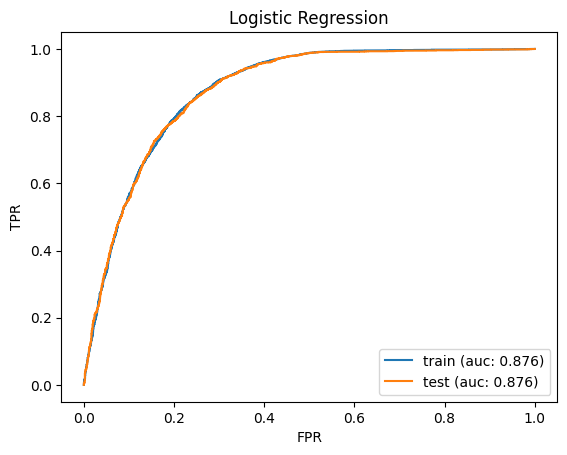

In [24]:
fpr_train, tpr_train, auc_train = roc(m_train, lr)
fpr_test, tpr_test, auc_test = roc(m_test, lr)

plt.plot(fpr_train, tpr_train, label='train (auc: %.3f)' % auc_train)
plt.plot(fpr_test, tpr_test, label='test (auc: %.3f)' % auc_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Logistic Regression')
plt.legend();

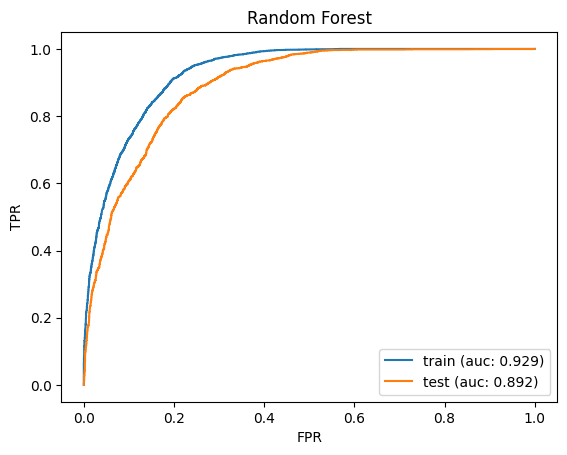

In [25]:
fpr_train, tpr_train, auc_train = roc(m_train, rf)
fpr_test, tpr_test, auc_test = roc(m_test, rf)

plt.plot(fpr_train, tpr_train, label='train (auc: %.3f)' % auc_train)
plt.plot(fpr_test, tpr_test, label='test (auc: %.3f)' % auc_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Random Forest')
plt.legend();